In [40]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

In [41]:
import numpy as np
from functools import partial
from scipy.spatial import cKDTree

# ATMO 5331 - Homework 5 & 6 - Fall 2023
## Due **Thursday** 30 Nov, 2023, 11:59 pm.
## *Worth two assignments*

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

**1.** Copy in your setup from HW3, so that you have the radar data, radar locations, and analysis grid available. Use only the tangent plane cartesian system part, and you don't need to include the plots. Take the time to clean up your original code so that it's the minimally necessary set of variables and functions.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
scan_idx = 1

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]

def centers_to_edges_1d(x):
    nx_edges = x.shape[0]+1
    xe = np.zeros(nx_edges)
    # Fill in the middle of the grid with average poitions
    xe[1:-1] = (x[1:] + x[:-1])/2.0
    # For the outermost points, use half the spacing of the center points closest to each end
    xe[0] = x[0] - (x[1] - x[0])/2.0
    xe[-1] = x[-1] + (x[-1] - x[-2])/2.0
    return xe

def spherical_coord_edges(d, scan_idx):
    start = d.sweep_start_ray_index[scan_idx].data
    stop = d.sweep_end_ray_index[scan_idx].data
    print(stop-start)
    r = d.range[:]
    r = centers_to_edges_1d(r.data)
    az = d.azimuth[start:stop]
    az = centers_to_edges_1d(az.data)
    el = d.elevation[start:stop]
    el = centers_to_edges_1d(el.data)
    return(r,az,el)
    
def coords_2d(d, scan_idx):
    r,az,el = spherical_coord_edges(d, scan_idx)
    r2D,az2d = np.meshgrid(r,az)
    r2D,el2d = np.meshgrid(r,el)   
    return(r2D, az2d, el2d)

r, az, el = coords_2d(d, scan_idx)

from coords import TangentPlaneCartesianSystem
from coords import RadarCoordinateSystem
r, az, el = coords_2d(d, scan_idx)

start = d.sweep_start_ray_index[scan_idx].data
stop = d.sweep_end_ray_index[scan_idx].data
ref = d.reflectivity[start:stop,:].data
velo = d.velocity[start:stop,:].data
SWidth = d.spectrum_width[start:stop,:].data
Power = d.normalized_coherent_power[start:stop,:].data

RadarObject = RadarCoordinateSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
TPlane = TangentPlaneCartesianSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
RadarX,RadarY,RadarZ = RadarObject.toECEF(r,az,el)
x,y,z = TPlane.fromECEF(RadarX,RadarY,RadarZ)
x.shape = r.shape
y.shape = r.shape
z.shape = r.shape

startrange = 9000
stoprange = 9505
steprange = 5

startalt = 2900
stopalt = 3405
stepalt = 5
rangearray = np.arange(startrange, stoprange, steprange)
altarray = np.arange(startalt, stopalt, steprange)


rangearray2D = centers_to_edges_1d(rangearray)
altarray2D = centers_to_edges_1d(altarray)

rangearray2D = rangearray2D[1:-1]
altarray2D = altarray2D[1:-1]

rangearray2D, altarray2D = np.meshgrid(rangearray2D, altarray2D)

from metpy.interpolate import interpolate_to_points
d = xr.open_dataset('Ka2140614021408.RAWPXA9.nc')

def spherical_coord_edges_fake(d, scan_idx):
    start = d.sweep_start_ray_index[scan_idx].data
    stop = d.sweep_end_ray_index[scan_idx].data
    print(stop-start)
    r = d.range[:]
    az = d.azimuth[start:stop]
    el = d.elevation[start:stop]
    return(r,az,el)
    
def coords_2d2(d, scan_idx):
    r,az,el = spherical_coord_edges_fake(d, scan_idx)
    r2D,az2d = np.meshgrid(r,az)
    r2D,el2d = np.meshgrid(r,el)   
    return(r2D, az2d, el2d)

r2D, az2D, el2D = coords_2d2(d, scan_idx)

start = d.sweep_start_ray_index[scan_idx].data
stop = d.sweep_end_ray_index[scan_idx].data
ref = d.reflectivity[start:stop,:].data
velo = d.velocity[start:stop,:].data
SWidth = d.spectrum_width[start:stop,:].data
Power = d.normalized_coherent_power[start:stop,:].data
RadarObject = RadarCoordinateSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
TPlane = TangentPlaneCartesianSystem(ctrLat = d.latitude.data,ctrLon = d.longitude.data, ctrAlt = d.altitude.data)
RadarX,RadarY,RadarZ = RadarObject.toECEF(r2D,az2D,el2D)
xnew,ynew,znew = TPlane.fromECEF(RadarX,RadarY,RadarZ)
x2D = xnew.flatten()
z2D = znew.flatten()

range2D = rangearray2D.flatten()
alt2D = altarray2D.flatten()

xnew = xnew.reshape(r2D.shape)
ynew = ynew.reshape(r2D.shape)
znew = znew.reshape(r2D.shape)

refflat = ref.flatten()
veloflat = velo.flatten()
SWidthflat = SWidth.flatten()
Powerflat = Power.flatten()

TrueSpot1 = (x2D >= 9000) & (x2D<= 9500)
TrueSpot2 = (z2D >= 2900) & (z2D<= 3400)
TrueSpot = TrueSpot1 & TrueSpot2
refTrue = refflat[TrueSpot]
veloTrue = veloflat[TrueSpot]
SWidthTrue = SWidthflat[TrueSpot]
PowerTrue = Powerflat[TrueSpot]
x2D = x2D[TrueSpot]
z2D = z2D[TrueSpot]

theStack = (np.vstack((x2D,z2D))).T
theStack2 = (np.vstack((range2D, alt2D))).T

refinterpLinear = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'linear')
refinterpNearestNeighbor = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'nearest')
refinterpBarnes = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'barnes')

rangenew = ((xnew**2)+(ynew**2))**0.5

585
585
585


**2.** Configuration of the weighting scheme requires that we know the typical data spacing. Following [TD2000](https://journals.ametsoc.org/view/journals/atot/17/2/1520-0426_2000_017_0105_rdoa_2_0_co_2.xml?tab_body=fulltext-display), define the data spacing as the distance betweent two radar gates at the maximum range. Use the point in your analysis grid that is farthest from the radar, and then find the maximum spacing in elevation angle at this range. Finally, calculate the difference in linear units between the two radar gates you idenified.

Please provide an answer to these two questions:
- What is the maximum distance from the radar in the objective analysis domain?
- What is the maximum spacing between two adjacent data points?

In [43]:
xNewDelta = xnew - 9500
zNewDelta = znew - 3400
rNewDelta = ((xNewDelta**2)+(zNewDelta**2))**0.5
rmaxindex = np.unravel_index(np.argmin(rNewDelta),rNewDelta.shape)
# Convert tuple to list, subtract 1, and convert back to tuple
rmaxindex = tuple(x - 1 for x in rmaxindex)

farthestDifference = ((xnew[rmaxindex]**2)+(znew[rmaxindex]**2))**0.5
print("The farthest distance in our analysis domain is: ", farthestDifference,"m")

def calculate_column_differences(matrix, column_number):
    differences = []
    for i in range(1, len(matrix)):
        diff = matrix[i][column_number] - matrix[i - 1][column_number]
        differences.append(diff)
    return differences
print(rangenew.shape
     )
deltaArray = calculate_column_differences(el,rmaxindex[0])
elMaxIndex = np.argmax(deltaArray)
rangeDifference = abs(rangenew[rmaxindex[0],elMaxIndex] - rangenew[rmaxindex[0]-1,elMaxIndex-1])
elDifference = abs(znew[rmaxindex[0],elMaxIndex] - znew[rmaxindex[0]-1,elMaxIndex-1])
endDifference = ((rangeDifference**2) +(elDifference**2))**0.5
print("The farthest distance between points in our analysis domain is: ", endDifference,"m")

The farthest distance in our analysis domain is:  10077.567151631572 m
(585, 1666)
The farthest distance between points in our analysis domain is:  18.579433102511867 m


**3.** Below, the function `oban` (for "objective analysis") mimics the call signature of the MetPy `interpolate_to_points` function. Its principal difference is the `weight_func` argument, which takes a function instead of a string describing an interpolation method. 

The `oban` function passes `weight_func` only the distances, so it is necessary to use `partial` to pre-fill the function with any other arguments needed to configure the weight function. The `sample_weights` function below shows how this works.

For fun, I've also included a seasonal illustration of the use of `partial`.

For this question, your jobs are as follows.

**a.**  Specify a cutoff radius. Based on the last homework assignment, what is a good distance to use as a multiple of the data spacing? Make sure to adjust your set of input data points to include the necessary margin beyond the perimeter of the analysis grid.

**b.**  Implement a `barnes` function and then use it with `oban` to calculate an analysis for reflectivity on the target grid.  Note that you will need to complete the `oban` function in a way that will work with any weight function.

**c.**  Calculate a Barnes analysis using MetPy, as in the last assignment, and find the difference (yours - MetPy). They probably won't be the same, even for a sane configuration of parameters; that's ok.

**d.**  Plot the original data, the two analyses, and the difference.


[ 6.86675257  6.88077203  6.87045925 ... -8.62554301 -9.0212478
 -9.37970401]


<Figure size 640x480 with 0 Axes>

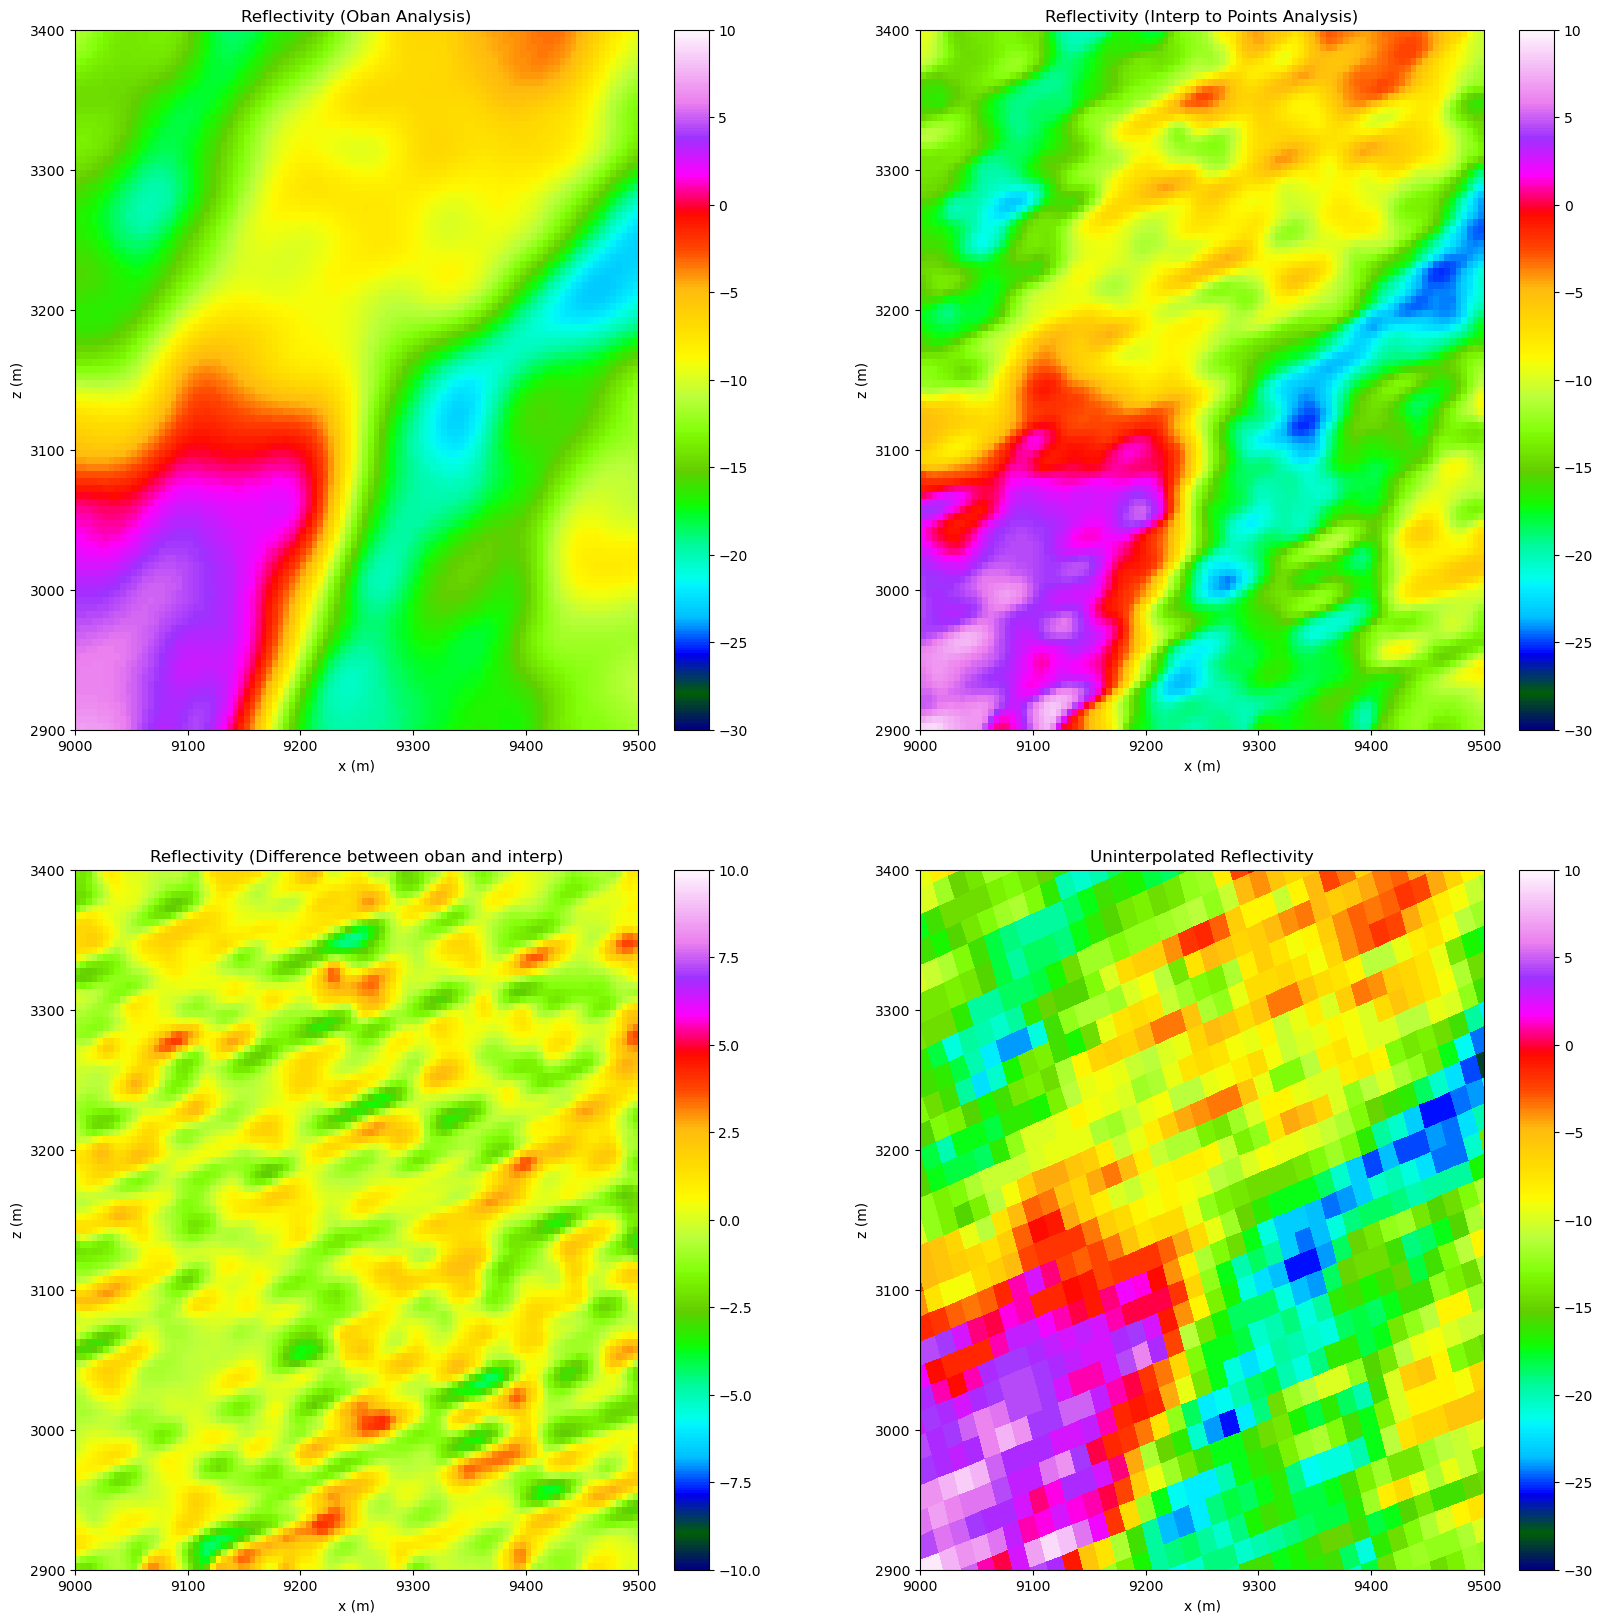

In [44]:
points = theStack

xi = theStack2
reflat = refTrue
delta = endDifference
search_radius = 3*delta
Ln = 2 * delta
fs = (1/delta)
fn = fs/2
kstar = 0.5
k = kstar*(Ln**2)

def oban(points, values, xi, weight_func, search_radius):
    """
    points: N,2 data point locations
    values: N data values
    xi: M,2 analysis locations
    weight_func is a function that accepts a single argument r that is the
        distance between the analysis location and all points within search_radius
        of the analysis location.
    """
    
    # Find all points in the vicinity of each analysis location in xi
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    analysis = np.zeros(xi.shape[0])
    
    # This is linear (times the typical neighborhood size) in the number of analysis points
    for i, (analysis_point, neighbors) in enumerate(zip(xi, query)):

        data = values[neighbors]
        data_locations = points[neighbors,:]
        data_locations_x = data_locations[:,0]
        data_locations_z = data_locations[:,1]
        delta_locations_x = data_locations_x - analysis_point[0]
        delta_locations_z = data_locations_z - analysis_point[1]
        delta_locations_r = ((delta_locations_x**2)+(delta_locations_z**2))**0.5
        weight = weight_func(delta_locations_r)
        normal_weight = weight/(np.sum(weight))
        # use data, data_locations, analysis_point, and weight_func to fill in the rest of the analysis
        analysis[i] = np.sum(normal_weight*data)
    return analysis, weight

def barnes(r, k):
    """ r has units of distance, and k is the dimensional weight parameter kappa
        kappa with units of distance squared.
        
        Returns the weights as a funcion of r.
    """
    w = np.exp((-(r)**2)/(k))
    return(w)
my_weight_func = partial(barnes, k=k)
obanAnalysis, obanAnalysisWeight  = oban(points,refTrue,xi,my_weight_func,search_radius)
refinterpBarnes = interpolate_to_points(theStack, refTrue, theStack2, interp_type = 'barnes')
print(obanAnalysis)
def BackTo2D(refinterpLinear):
    num_rows = 100
    num_elements_per_row = len(refinterpLinear) // num_rows
    refinterpLinear2D = refinterpLinear[:num_elements_per_row * num_rows].reshape(num_rows, num_elements_per_row)
    return(refinterpLinear2D)

obanAnalysis2D = BackTo2D(obanAnalysis)
refinterpBarnes2D = BackTo2D(refinterpBarnes)
obanInterpDiff = obanAnalysis2D - refinterpBarnes2D

fig = plt.figure()
n_rows,n_cols = 2,2,
fig,axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes[0,0].plot
axes[0,0].set_xlabel('x (m)')
axes[0,0].set_ylabel('z (m)')
axes[0,0].set_title('Reflectivity (Oban Analysis)')
refplotter = axes[0,0].pcolormesh(rangearray, altarray, obanAnalysis2D, cmap='gist_ncar', vmin=-30, vmax=10)
plt.colorbar(refplotter)


axes[0,1].plot
axes[0,1].set_xlabel('x (m)')
axes[0,1].set_ylabel('z (m)')
axes[0,1].set_title('Reflectivity (Interp to Points Analysis)')
veloplotter = axes[0,1].pcolormesh(rangearray, altarray, refinterpBarnes2D, cmap='gist_ncar', vmin=-30, vmax=10)
plt.colorbar(veloplotter)

axes[1,0].plot
axes[1,0].set_xlabel('x (m)')
axes[1,0].set_ylabel('z (m)')
axes[1,0].set_title('Reflectivity (Difference between oban and interp)')
SWidthplotter = axes[1,0].pcolormesh(rangearray, altarray, obanInterpDiff, cmap='gist_ncar', vmin=-10, vmax=10)
plt.colorbar(SWidthplotter)

axes[1,1].plot
axes[1,1].set_xlabel('x (m)')
axes[1,1].set_ylabel('z (m)')
axes[1,1].set_title('Uninterpolated Reflectivity')
Powerplotter = axes[1,1].pcolormesh(x, z, ref.data, cmap='gist_ncar', vmin=-30, vmax=10)
axes[1, 1].set_xlim(9000, 9500)
axes[1, 1].set_ylim(2900, 3400)
plt.colorbar(Powerplotter)

**4.** Let's say we want to use another filter from [Harris (1978)](https://ieeexplore.ieee.org/iel5/5/31261/01455106.pdf?casa_token=nY_Vus-tiGQAAAAA:1K1Z17V0-r1wCpI7TlY0OFKZGTTtigj1xTtyLAj_DEkaAVYnkDVUh7Kl0BLFJjQZ4647zYZJm4c-) for our continuous data. Those functions are specified for discrete data, with a hard cutoff after $N$ samples. It would be logical to cut off all our analyses after the same cutoff radius for all data, so that our understanding of the filter function sidelobe behavior from discrete theory can be applied to continous data in an even-handed way.

So, let's repeat the previous question, but now using the Rectangular and Blackman-Harris weights. You will need to use Harris (1978) for the mathematical formulation of the windows, as defined below.

**a.**  Implement a `rect` function and then use it with `oban` to calculate an analysis on the target grid.

**b.**  Implement a `blackman_harris` function and then use it with `oban` to calculate an analysis on the target grid. Use the minimum 4-term Blackman-Harris formulation as in the `scipy.signal.blackmanharris` docs whose coefficients are the -92 dB 4-term window in the table on p. 65 of Harris.

**c.**  Include in this notebook, using a Markdown cell and the $\LaTeX$ functionality, a narrated derivation that shows how you converted the discrete, non-dimensional formulation of the Blackman-Harris weight function to a continuous, dimensional form.

**d.**  Make a plot of the weight functions as a function of distance from zero to your cutoff radius.

**e.**  Plot the original data and the two analyses.



<Figure size 640x480 with 0 Axes>

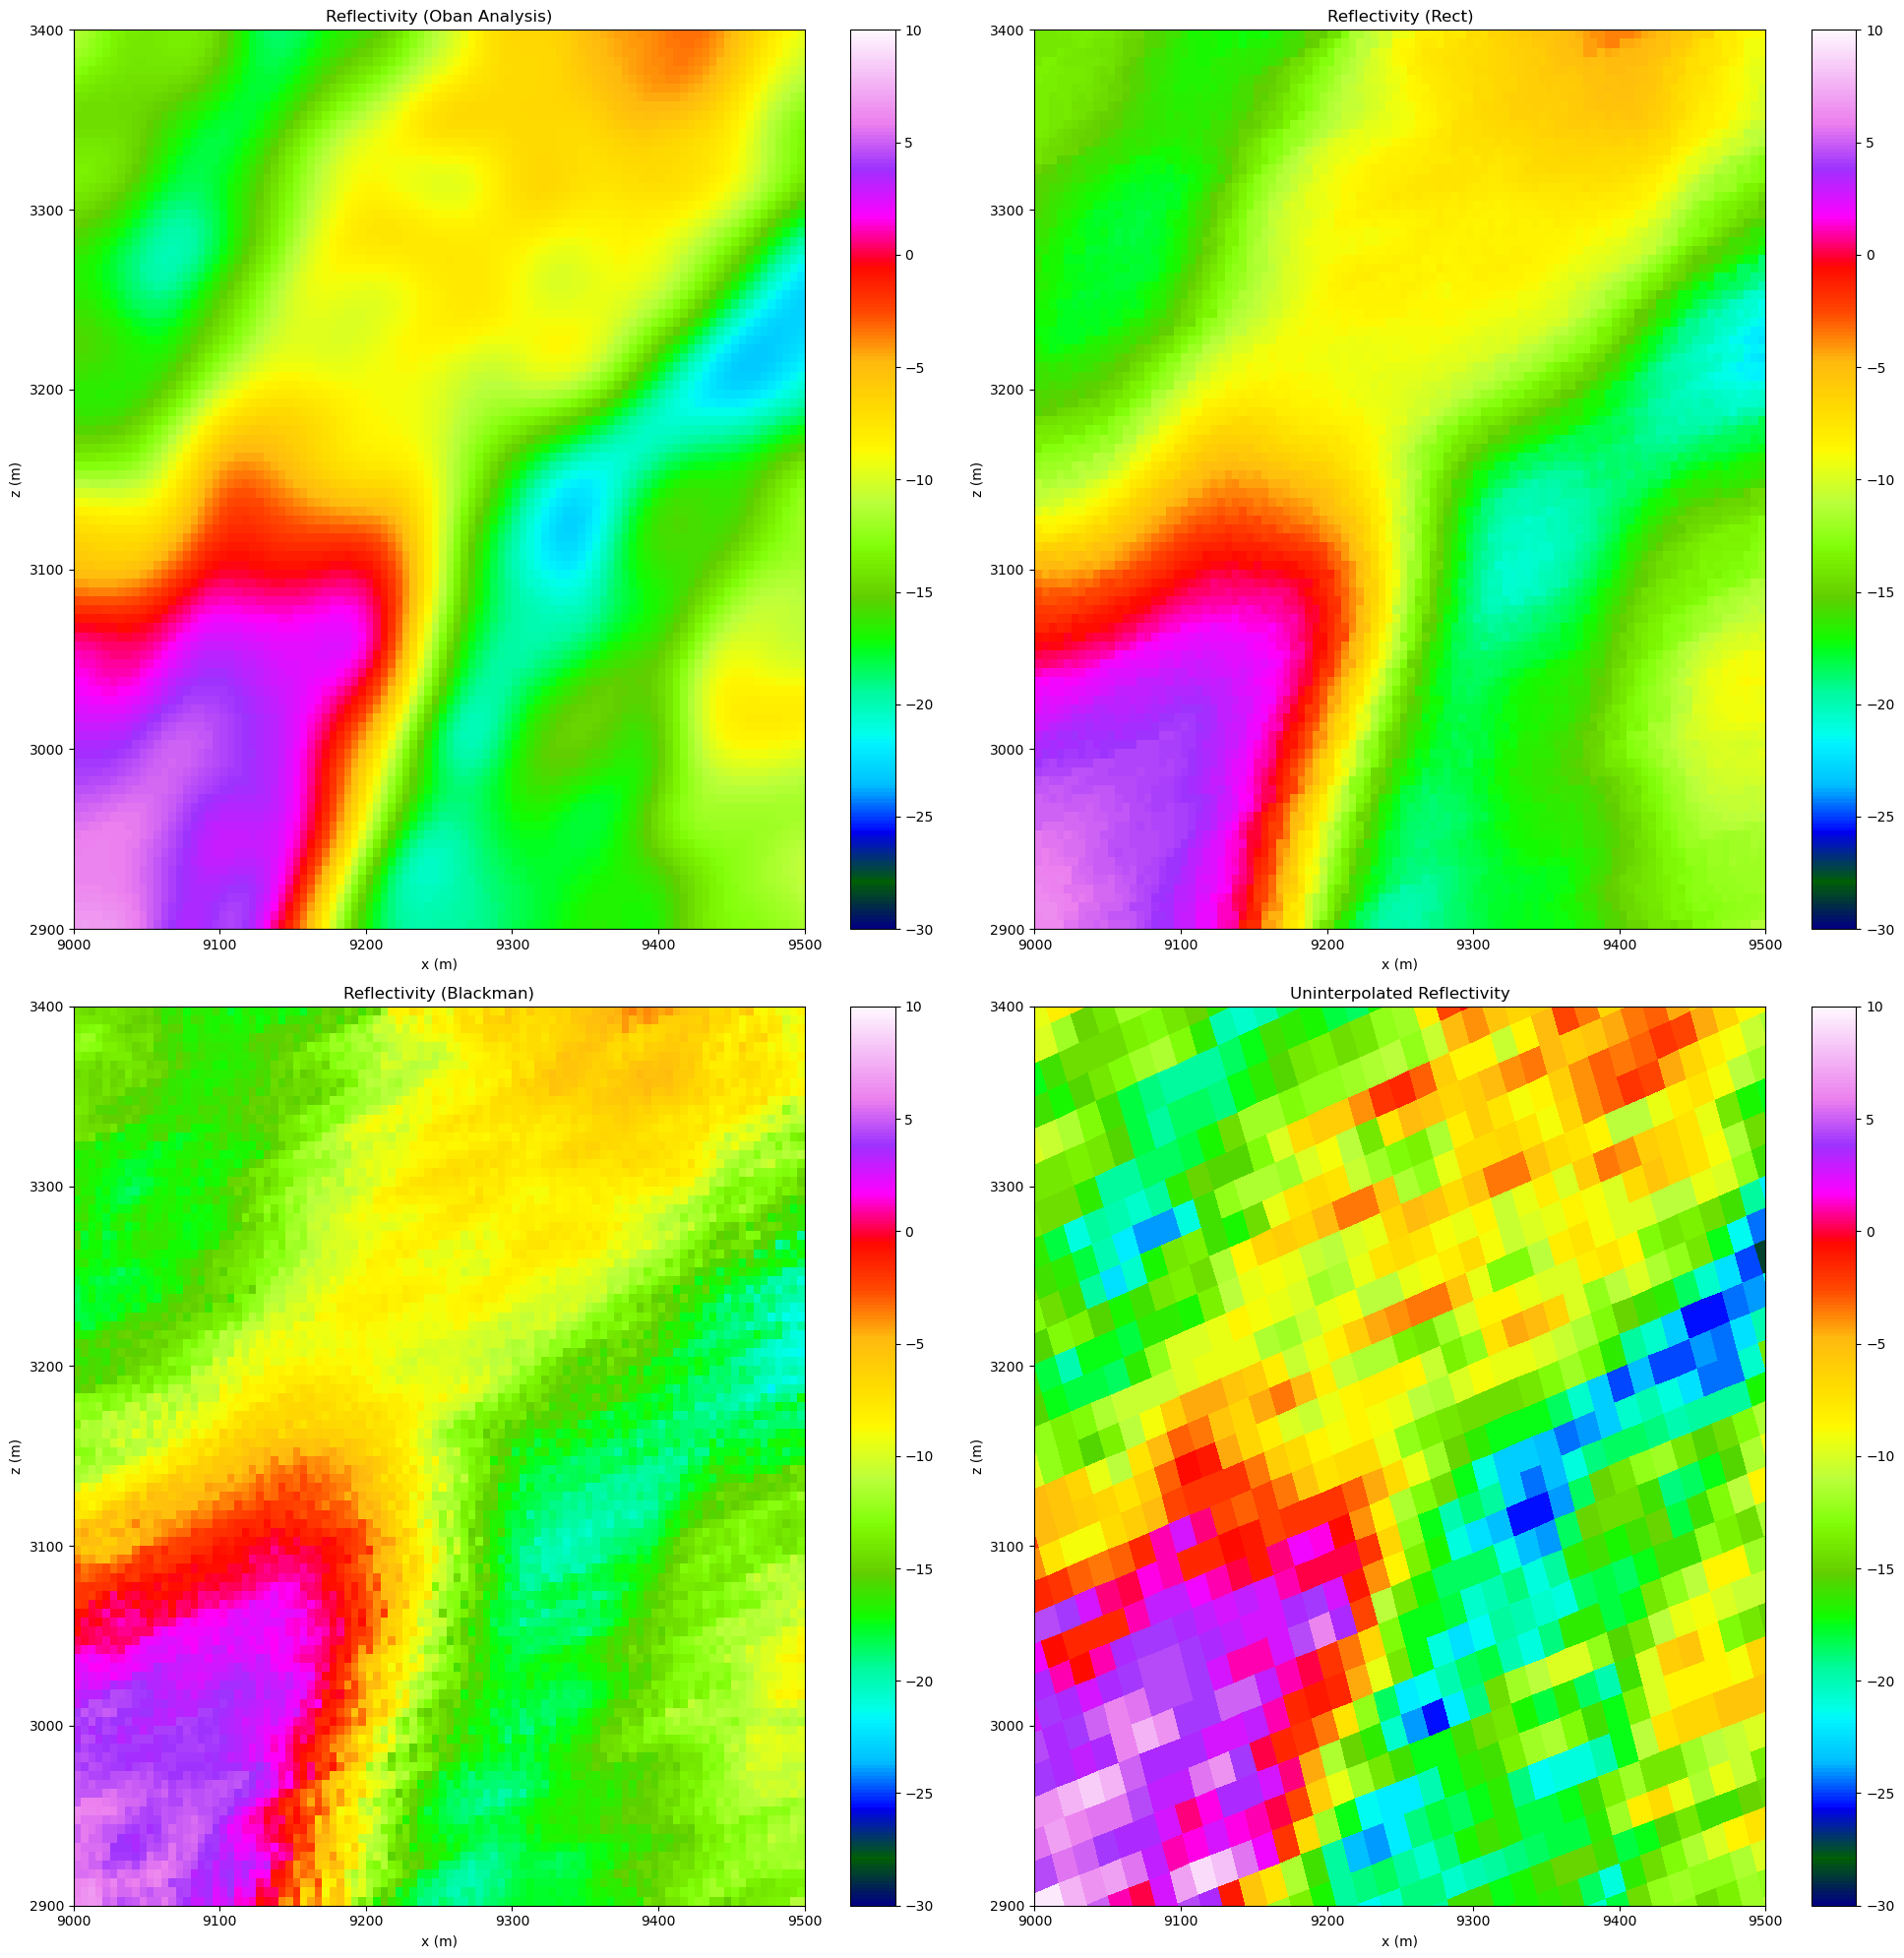

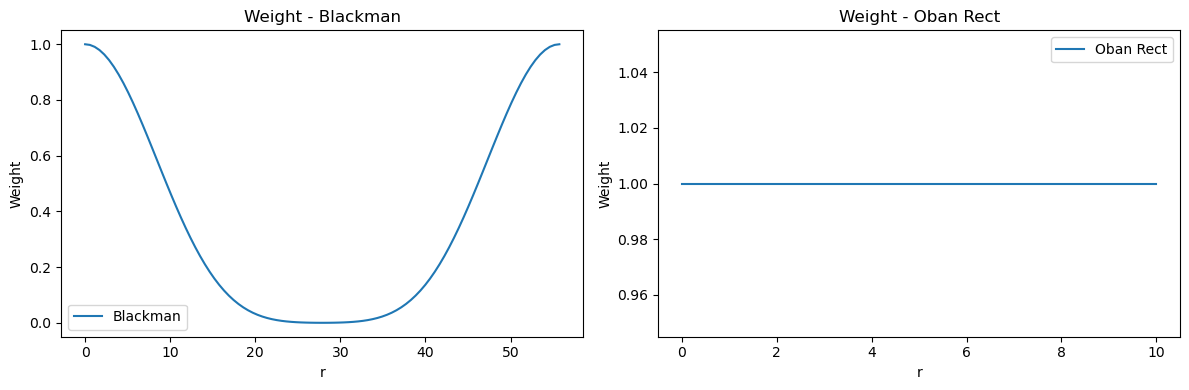

In [45]:
def useless(r):
    rect = np.ones_like(r)
    return rect
my_weight_func = partial(useless)
obanAnalysisRect, weightObanRect = oban(points,refTrue,xi,my_weight_func,search_radius)


def blackman(n, N):
    a0 = 0.35875
    a1 = 0.48829
    a2 = 0.14128
    a3 = 0.01168
    w = (a0 
        - ( a1 * np.cos( ((2*(np.pi))/N) * (n+(N/2)) ))
        + (a2*np.cos(((2*(np.pi))/N)*(2*(n+(N/2)))))
        - (a3*np.cos(((2*(np.pi))/N)*(3*(n+(N/2))))))
    return w

my_weight_func = partial(blackman, N=search_radius)
obanAnalysisBlackman, weightObanBlackman = oban(points,refTrue,xi,my_weight_func,search_radius)
obanAnalysisRect2D = BackTo2D(obanAnalysisRect)
obanAnalysisBlackman2D = BackTo2D(obanAnalysisBlackman)
fig = plt.figure()
n_rows, n_cols = 2, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))

axes[0, 0].set_xlabel('x (m)')
axes[0, 0].set_ylabel('z (m)')
axes[0, 0].set_title('Reflectivity (Oban Analysis)')
refplotter = axes[0, 0].pcolormesh(rangearray, altarray, obanAnalysis2D, cmap='gist_ncar', vmin=-30, vmax=10)
plt.colorbar(refplotter)



axes[0, 1].set_xlabel('x (m)')
axes[0, 1].set_ylabel('z (m)')
axes[0, 1].set_title('Reflectivity (Rect)')
SWidthplotter = axes[0, 1].pcolormesh(rangearray, altarray, obanAnalysisRect2D, cmap='gist_ncar', vmin=-30, vmax=10)
plt.colorbar(SWidthplotter)

axes[1, 0].set_xlabel('x (m)')
axes[1, 0].set_ylabel('z (m)')
axes[1, 0].set_title('Reflectivity (Blackman)')
Powerplotter = axes[1, 0].pcolormesh(rangearray, altarray, obanAnalysisBlackman2D, cmap='gist_ncar', vmin=-30, vmax=10)
axes[1, 0].set_xlim(9000, 9500)
axes[1, 0].set_ylim(2900, 3400)
plt.colorbar(Powerplotter)

axes[1, 1].set_xlabel('x (m)')
axes[1, 1].set_ylabel('z (m)')
axes[1, 1].set_title('Uninterpolated Reflectivity')
Uninterpplotter = axes[1, 1].pcolormesh(x, z, ref.data, cmap='gist_ncar', vmin=-30, vmax=10)  # Replace with your data array
axes[1, 1].set_xlim(9000, 9500)
axes[1, 1].set_ylim(2900, 3400)
plt.colorbar(Uninterpplotter)

plt.tight_layout()
plt.show()


fake_array = np.linspace(0, search_radius, 100)
weightBlackman = blackman(fake_array, search_radius)

# Create a new figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot weightBlackman
axes[0].plot(fake_array, weightBlackman, label='Blackman')
axes[0].set_title('Weight - Blackman')
axes[0].set_xlabel('r')
axes[0].set_ylabel('Weight')
axes[0].legend()

# Plot weightObanRect
axes[1].plot(weightObanRect, label='Oban Rect')
axes[1].set_title('Weight - Oban Rect')
axes[1].set_xlabel('r')
axes[1].set_ylabel('Weight')
axes[1].legend()

plt.tight_layout()
plt.show()



In order to convert the formula:
$
\newline
[ W_{\text{BH}}(r, N) = a_0 - a_1 \cos\left(\frac{2\pi}{N} r\right) + a_2 \cos\left(\frac{4\pi}{N} r\right) - a_3 \cos\left(\frac{6\pi}{N} r\right) ]
\newline
$
to a continuous and discrete form, I phase-shifted it by $( \frac{N}{2} )$ and ended up with this equation:
$
\newline
[ W_{\text{BH}}(n, N) = a_0 - a_1 \cos\left(\frac{2\pi}{N} (n + \frac{N}{2})\right) + a_2 \cos\left(\frac{4\pi}{N} (n + \frac{N}{2})\right) - a_3 \cos\left(\frac{6\pi}{N} (n + \frac{N}{2})\right) ]
$

**5.** Let's compare the different filters.

**a.** Plot the original data, and using the Barnes filter as a common point of comparison, plot the difference with the other two analyses you calculated.

**b.** Which weighting scheme preserves the greatest detail in fine-scale structure? Illustrate this by discussing a local minimum and a local maximum in the original data vs. the difference fields. Does it make sense in terms of the theoretical response functions we calcualted in the previous homework?

<Figure size 640x480 with 0 Axes>

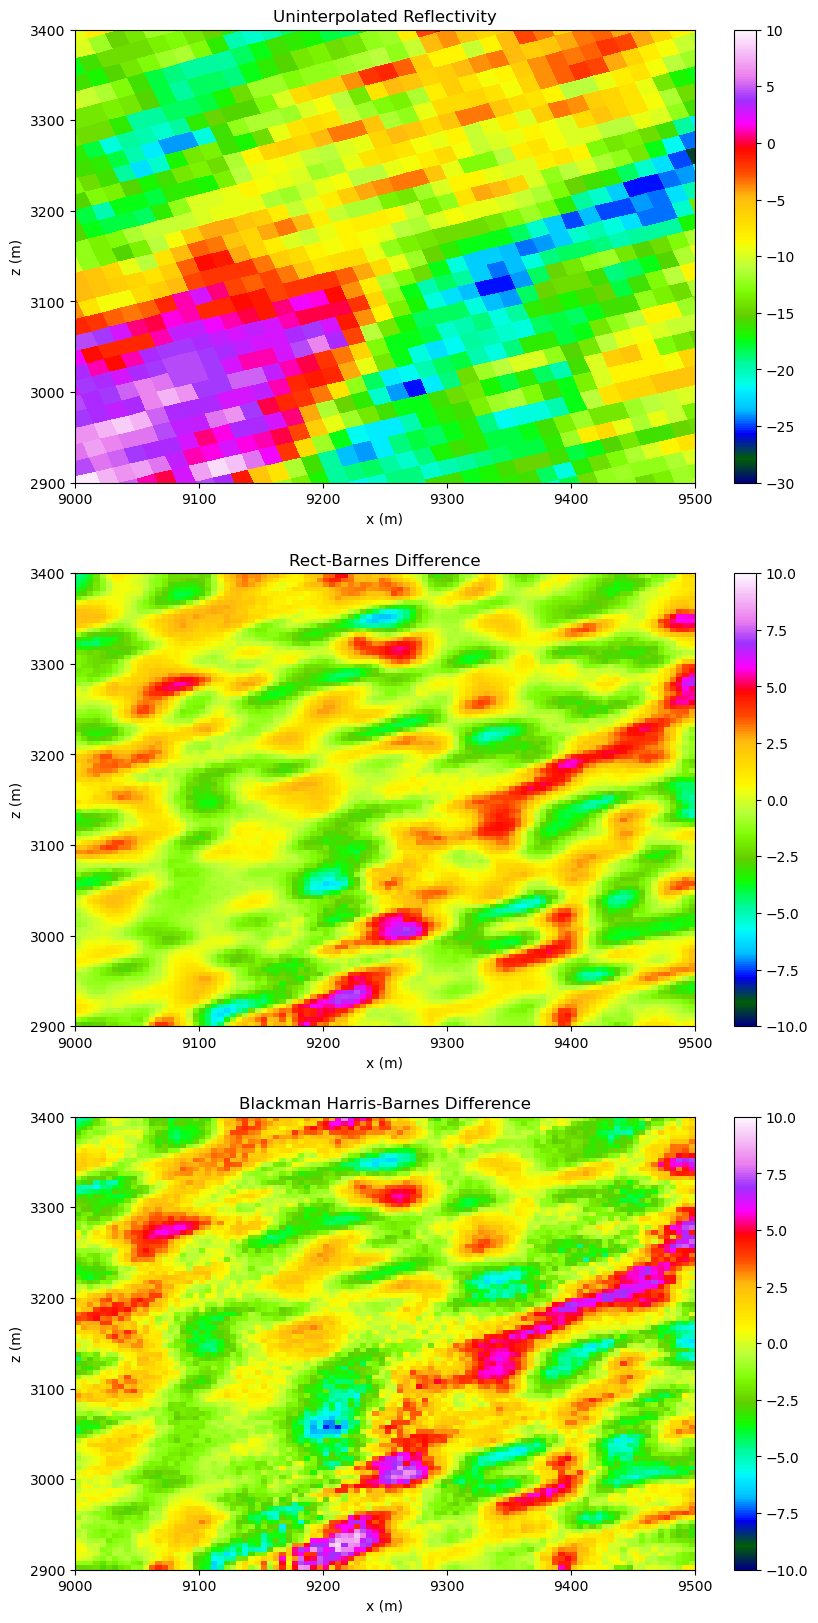

In [46]:
fig = plt.figure()
n_rows, n_cols = 3, 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 20))

obanRectDiff = obanAnalysisRect2D - refinterpBarnes2D
obanBlackmanDiff = obanAnalysisBlackman2D - refinterpBarnes2D


axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('z (m)')
axes[0].set_title('Uninterpolated Reflectivity')
Uninterpplotter = axes[0].pcolormesh(x, z, ref.data, cmap='gist_ncar', vmin=-30, vmax=10)  # Replace with your data array
axes[0].set_xlim(9000, 9500)
axes[0].set_ylim(2900, 3400)
plt.colorbar(Uninterpplotter)


axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('z (m)')
axes[1].set_title('Rect-Barnes Difference')
obanRectDiffPlot = axes[1].pcolormesh(rangearray, altarray, obanRectDiff, cmap='gist_ncar', vmin=-10, vmax=10)  # Replace with your data array
axes[1].set_xlim(9000, 9500)
axes[1].set_ylim(2900, 3400)
plt.colorbar(obanRectDiffPlot)


axes[2].set_xlabel('x (m)')
axes[2].set_ylabel('z (m)')
axes[2].set_title('Blackman Harris-Barnes Difference')
obanBlackmanDiffPlot = axes[2].pcolormesh(rangearray, altarray, obanBlackmanDiff, cmap='gist_ncar', vmin=-10, vmax=10)  # Replace with your data array
axes[2].set_xlim(9000, 9500)
axes[2].set_ylim(2900, 3400)
plt.colorbar(obanBlackmanDiffPlot)


In [47]:

print('The weighting function that preserves the most fine scale detail is absolutely Blackman-Harris. In almost every patch in the difference plot you cans ee where the Rect is significantly smoother than the Blackman Harris. In order to point this out at one point specifically, I would focus in the top right, where rect significantly smooths over some of the lower reflectivity values and Blackman Harris still resolves streaks of reflectivity. Yes this is exactly the result we would expect based on our response functions from the previous homework, where Blackman Harris outperformed other filters.')

The weighting function that preserves the most fine scale detail is absolutely Blackman-Harris. In almost every patch in the difference plot you cans ee where the Rect is significantly smoother than the Blackman Harris. In order to point this out at one point specifically, I would focus in the top right, where rect significantly smooths over some of the lower reflectivity values and Blackman Harris still resolves streaks of reflectivity. Yes this is exactly the result we would expect based on our response functions from the previous homework, where Blackman Harris outperformed other filters.
